# Fit an image model to the HD 98800 Band 6 ALMA uv data

In [1]:
import os
import copy
import numpy as np
import emcee
import scipy.optimize
import matplotlib.pyplot as plt
import corner
import galario.double as gd
from galario import arcsec
from uvplot import UVTable

import alma.image

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# notes
Here there are two observations, we'll want to check that they are consistent before combining

s/n is so high it looks like modelling only a narrow band is needed

In [2]:
# import the data, this assumes we're getting the output from uvplot
# uv_file = '../../../data/alma/hd98800-b6/uv-w32-t20-X7bf8-spw0.txt'
uv_file = '../../../data/alma/hd98800-b6/uv-w32-t20-spw04.txt'
u, v, Re, Im, w = np.require( np.loadtxt(uv_file, unpack=True),requirements=["C_CONTIGUOUS"])

# meaning we can get the mean wavelength like so
with open(uv_file) as f:
    _ = f.readline()
    tmp = f.readline()

wavelength = float(tmp.strip().split('=')[1])
print('wavelength is {} mm'.format(wavelength*1e3))
    
u /= wavelength
v /= wavelength

# re-weight so that chi^2 for null model is 1
reweight_factor = np.sum( ( Re**2.0 + Im**2.0) * w ) / len(w)
print('reweighting factor is {}'.format(reweight_factor))
w /= reweight_factor

wavelength is 1.3116875614 mm
reweighting factor is 5.843439638517149


In [3]:
# set image properties, can cut dxy down for speed (at the cost of reduced accuracy)
nxy, dxy = gd.get_image_size(u, v, verbose=True, f_max=2.5)
dxy_arcsec = dxy / arcsec

dxy:4.634847e-03arcsec	nxy_MRS:2048
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:1.898433e+00arcsec


In [4]:
# decide what model we want to use, and where we will put the results
model_name = 'power_2d_ecc_rin'
if not os.path.exists(model_name):
    os.mkdir(model_name)

In [5]:
# make the image object
ii = alma.image.Image(arcsec_pix=dxy_arcsec, image_size=(nxy, nxy), emit_model='rj_tail',
                      dens_model=model_name, z_fact=2, dens_args={'box_half_height':0.05},
                      wavelength=wavelength, model='los_image')

# starting params
p0 = np.array([-0.06118069,  0.61998539 , 1.59623187e+01,  2.67843985e+01,
  4.72869314e-02,  7.44299430e-02 , 2.20765315e-02, 3.71784753e-05]) # gauss_2d
p0 = np.array([-0.06118069,  0.61998539 , 1.5709468e+01  ,2.63427e+01,
  4.71773951e-02 , 5.56782501e-02 , 10.24798055e-02, -2.00537e+00]) # box_2d, no tau
# p0 = np.array([-0.06118069,  0.61998539, 15.70151213, 26.43888517,  0.04737159,  0.0559053,
#   0.10211317, -1.87350207]) # power_2d
p0 = np.array([-6.12502092e-02 , 6.20182526e-01 , 1.59288391e+01, -80.3568272,
  2.62195359e+01,  4.73734254e-02 , 5.63211957e-02 , 1.02322118e-01,
 -2.06857650e+00,  2.71088936e-02]) # power_2d_ecc_rin

model:los_image with density:power_2d_ecc_rin and emit:rj_tail
parameters are ['$x_0$', '$y_0$', '$\\Omega$', '$\\omega$', '$i$', '$F$', '$r_{in}$', '$r_{out}$', '$\\alpha$', '$e_{in}$']
rmax not set, run compute_rmax before generating images


In [6]:
labels = ii.params #np.append(ii.params,['$\\tau$'])
p_ranges = ii.p_ranges #+ [[0,10]]

print('parameters and ranges for {}'.format(model_name))
for i in range(len(p0)):
    print('{:g}  \t{}  \t{}'.format(p0[i],p_ranges[i],labels[i]))

parameters and ranges for power_2d_ecc_rin
-0.0612502  	[-1, 1]  	$x_0$
0.620183  	[-1, 1]  	$y_0$
15.9288  	[-270, 270]  	$\Omega$
-80.3568  	[-270, 270]  	$\omega$
26.2195  	[0.0, 120]  	$i$
0.0473734  	[0.0, inf]  	$F$
0.0563212  	[0.0, inf]  	$r_{in}$
0.102322  	[0.0, inf]  	$r_{out}$
-2.06858  	[-inf, inf]  	$\alpha$
0.0271089  	[0.0, 1.0]  	$e_{in}$


radial r_max: 22 pix at -13.215153554363463,133.80864196008346
model x,y,z extent 21, 22, 23
27 ms ± 260 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


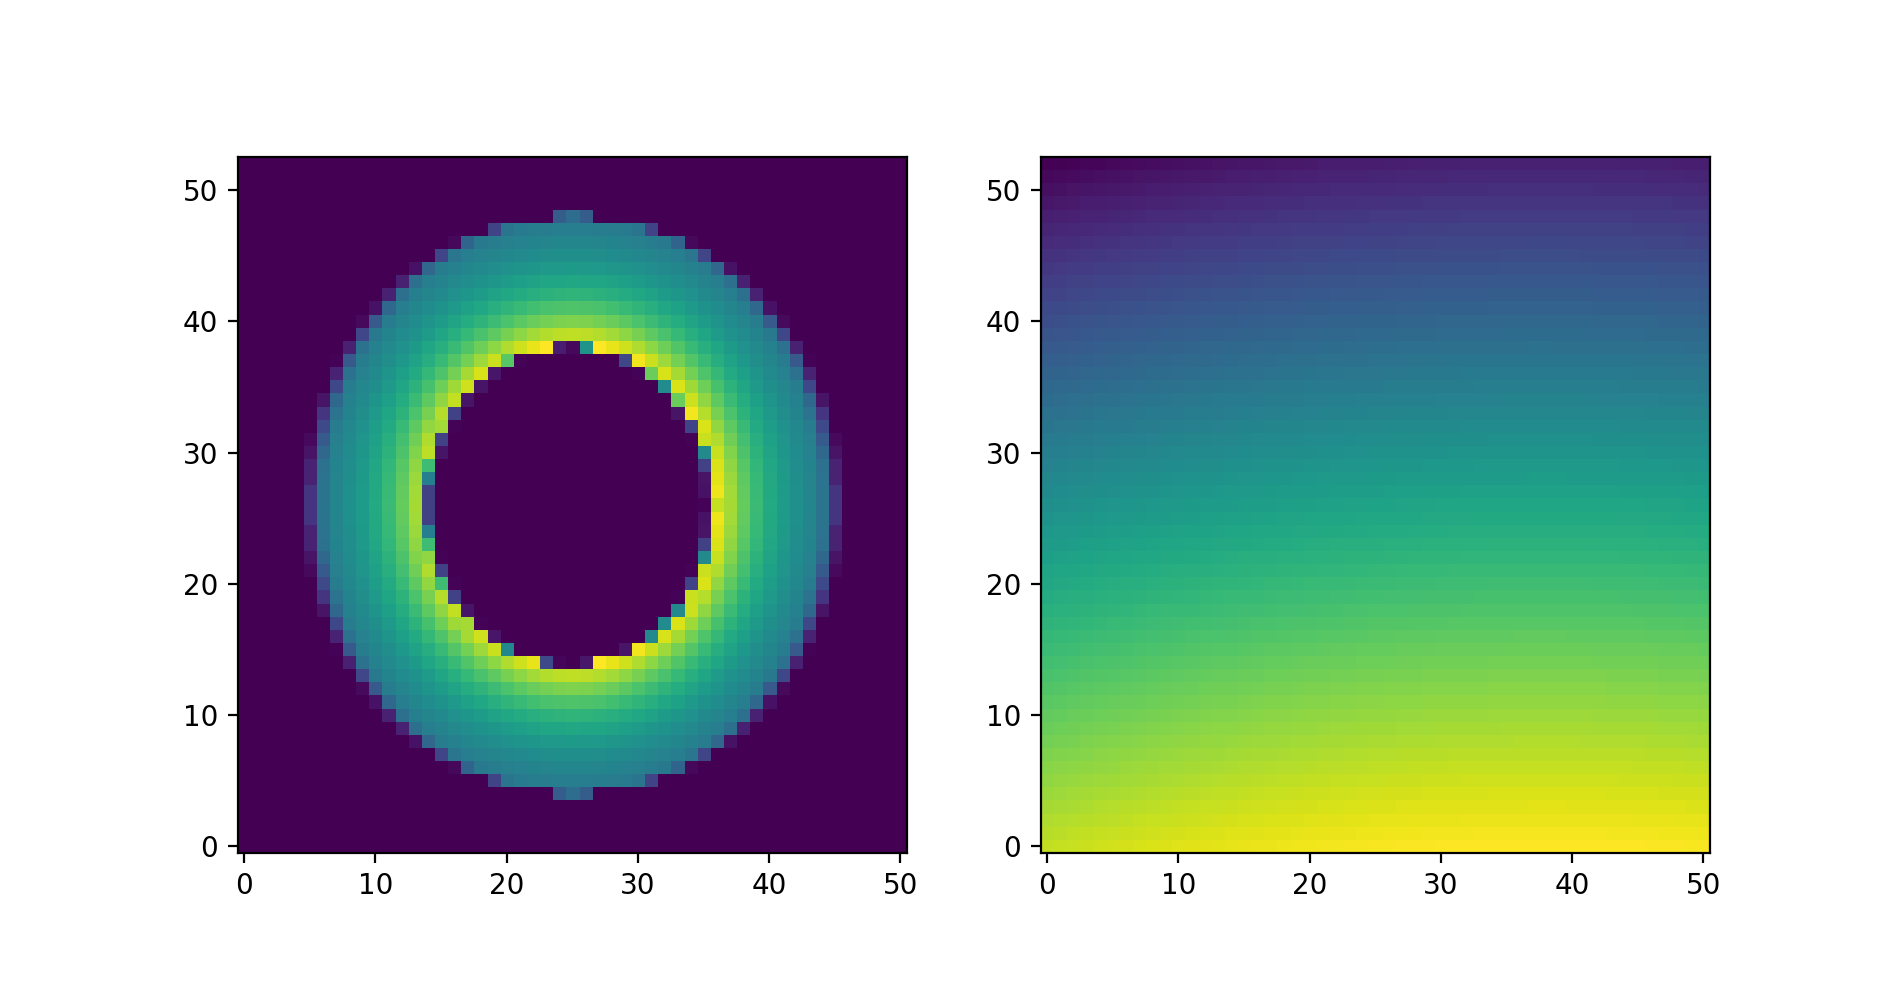

In [7]:
# set rmax based on these params, tolerance in compute_rmax might be
# varied if the crop size turns out too large
ii.compute_rmax(p0, tol=1e-2, expand=5, zero_node=True)

# this gives an idea of how long an mcmc might take
%timeit ii.image_galario(p0[3:])

# show an image and the primary beam
im = ii.image_galario(p0[3:])
fig,ax = plt.subplots(1,2, figsize=(9.5,5))
ax[0].imshow(im[ii.cc_gal], origin='bottom')
ax[1].imshow(ii.pb_galario[ii.cc_gal], origin='bottom')

In [8]:
def lnpostfn(p):
    """ Log of posterior probability function """

    for x,r in zip(p, p_ranges):
        if x < r[0] or x > r[1]:
            return -np.inf
    if p[5] > p[6]:
        return -np.inf

    # we generate the image with PA = North, including primary beam correction
    image = ii.image_galario(p[3:]) * ii.pb_galario

    # apply optical depth
#     image = 1 - np.exp(-image/p[-1])
#     image = p[4] * image / np.sum(image)

    # galario  translates and rotates it for us
    chi2 = gd.chi2Image(image, dxy, u, v, Re, Im, w,
                        dRA = p[0]*arcsec, dDec = p[1]*arcsec, PA = np.deg2rad(p[2]) )
    return -0.5 * chi2

nlnpostfn = lambda p: -lnpostfn(p)

In [17]:
# get a best fit to estimate mcmc starting params
# res = scipy.optimize.minimize(nlnpostfn, p0, method='Nelder-Mead',
#                              options={'maxiter':10})
# print(res['message'],-res['fun'], res['x'])
# p0 = np.array(res['x'])

# show the image, before translation and rotation
# fig,ax = plt.subplots()
# im = ii.image_galario(p0[3:])
# ax.imshow(im[ii.cc_gal],origin='bottom')

In [10]:
# set up and run mcmc fitting
ndim = len(p0)          # number of dimensions
nwalkers = 64           # number of walkers
nsteps = 2000           # total number of MCMC steps
nthreads = 8            # CPU threads that emcee should use

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpostfn, threads=nthreads)

# initialize the walkers with an ndim-dimensional Gaussian ball
# pos = [p0 + p0*0.01*np.random.randn(ndim) for i in range(nwalkers)]
tmp = np.load(model_name+'/chains-'+model_name+'.npz')
pos = tmp['arr_0'][:,-1,:]

# execute the MCMC
pos, prob, state = sampler.run_mcmc(pos, nsteps)

In [11]:
# save the chains to file
np.savez_compressed(model_name+'/chains-'+model_name+'.npz', sampler.chain, sampler.lnprobability)

In [12]:
# load previous results
# tmp = np.load(model_name+'/chains-'+model_name+'.npz')
# chain = tmp['arr_0']
# lnprobability = tmp['arr_1']
# ndim = chain.shape[2]
# nwalkers = chain.shape[0]
# nsteps = chain.shape[1]
# burn=1000
# chain.shape

(64, 2000, 10)

In [12]:
sampler.get_autocorr_time(c=1)

array([82.32585228, 74.6570821 , 94.93442191, 69.65758722, 74.07155635,
       85.15196822, 84.95205313, 67.62022779])

<IPython.core.display.Javascript object>


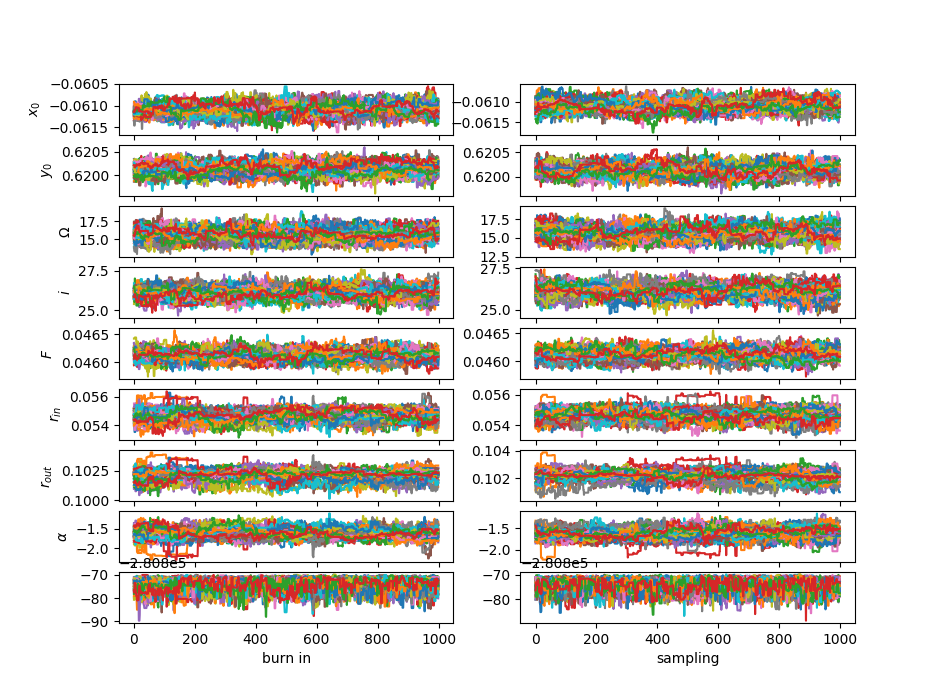

In [13]:
# see what the chains look like, skip a burn in period if desired
burn = 1000
fig,ax = plt.subplots(ndim+1,2,figsize=(9.5,7),sharex='col',sharey=False)

for j in range(nwalkers):
    ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[j,:burn,i])
        ax[i,0].set_ylabel(labels[i])

for j in range(nwalkers):
    ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(ndim):
        ax[i,1].plot(sampler.chain[j,burn:,i])
#         ax[i,1].set_ylabel(ii.params[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')
fig.savefig(model_name+'/chains-'+model_name+'.png')

<IPython.core.display.Javascript object>


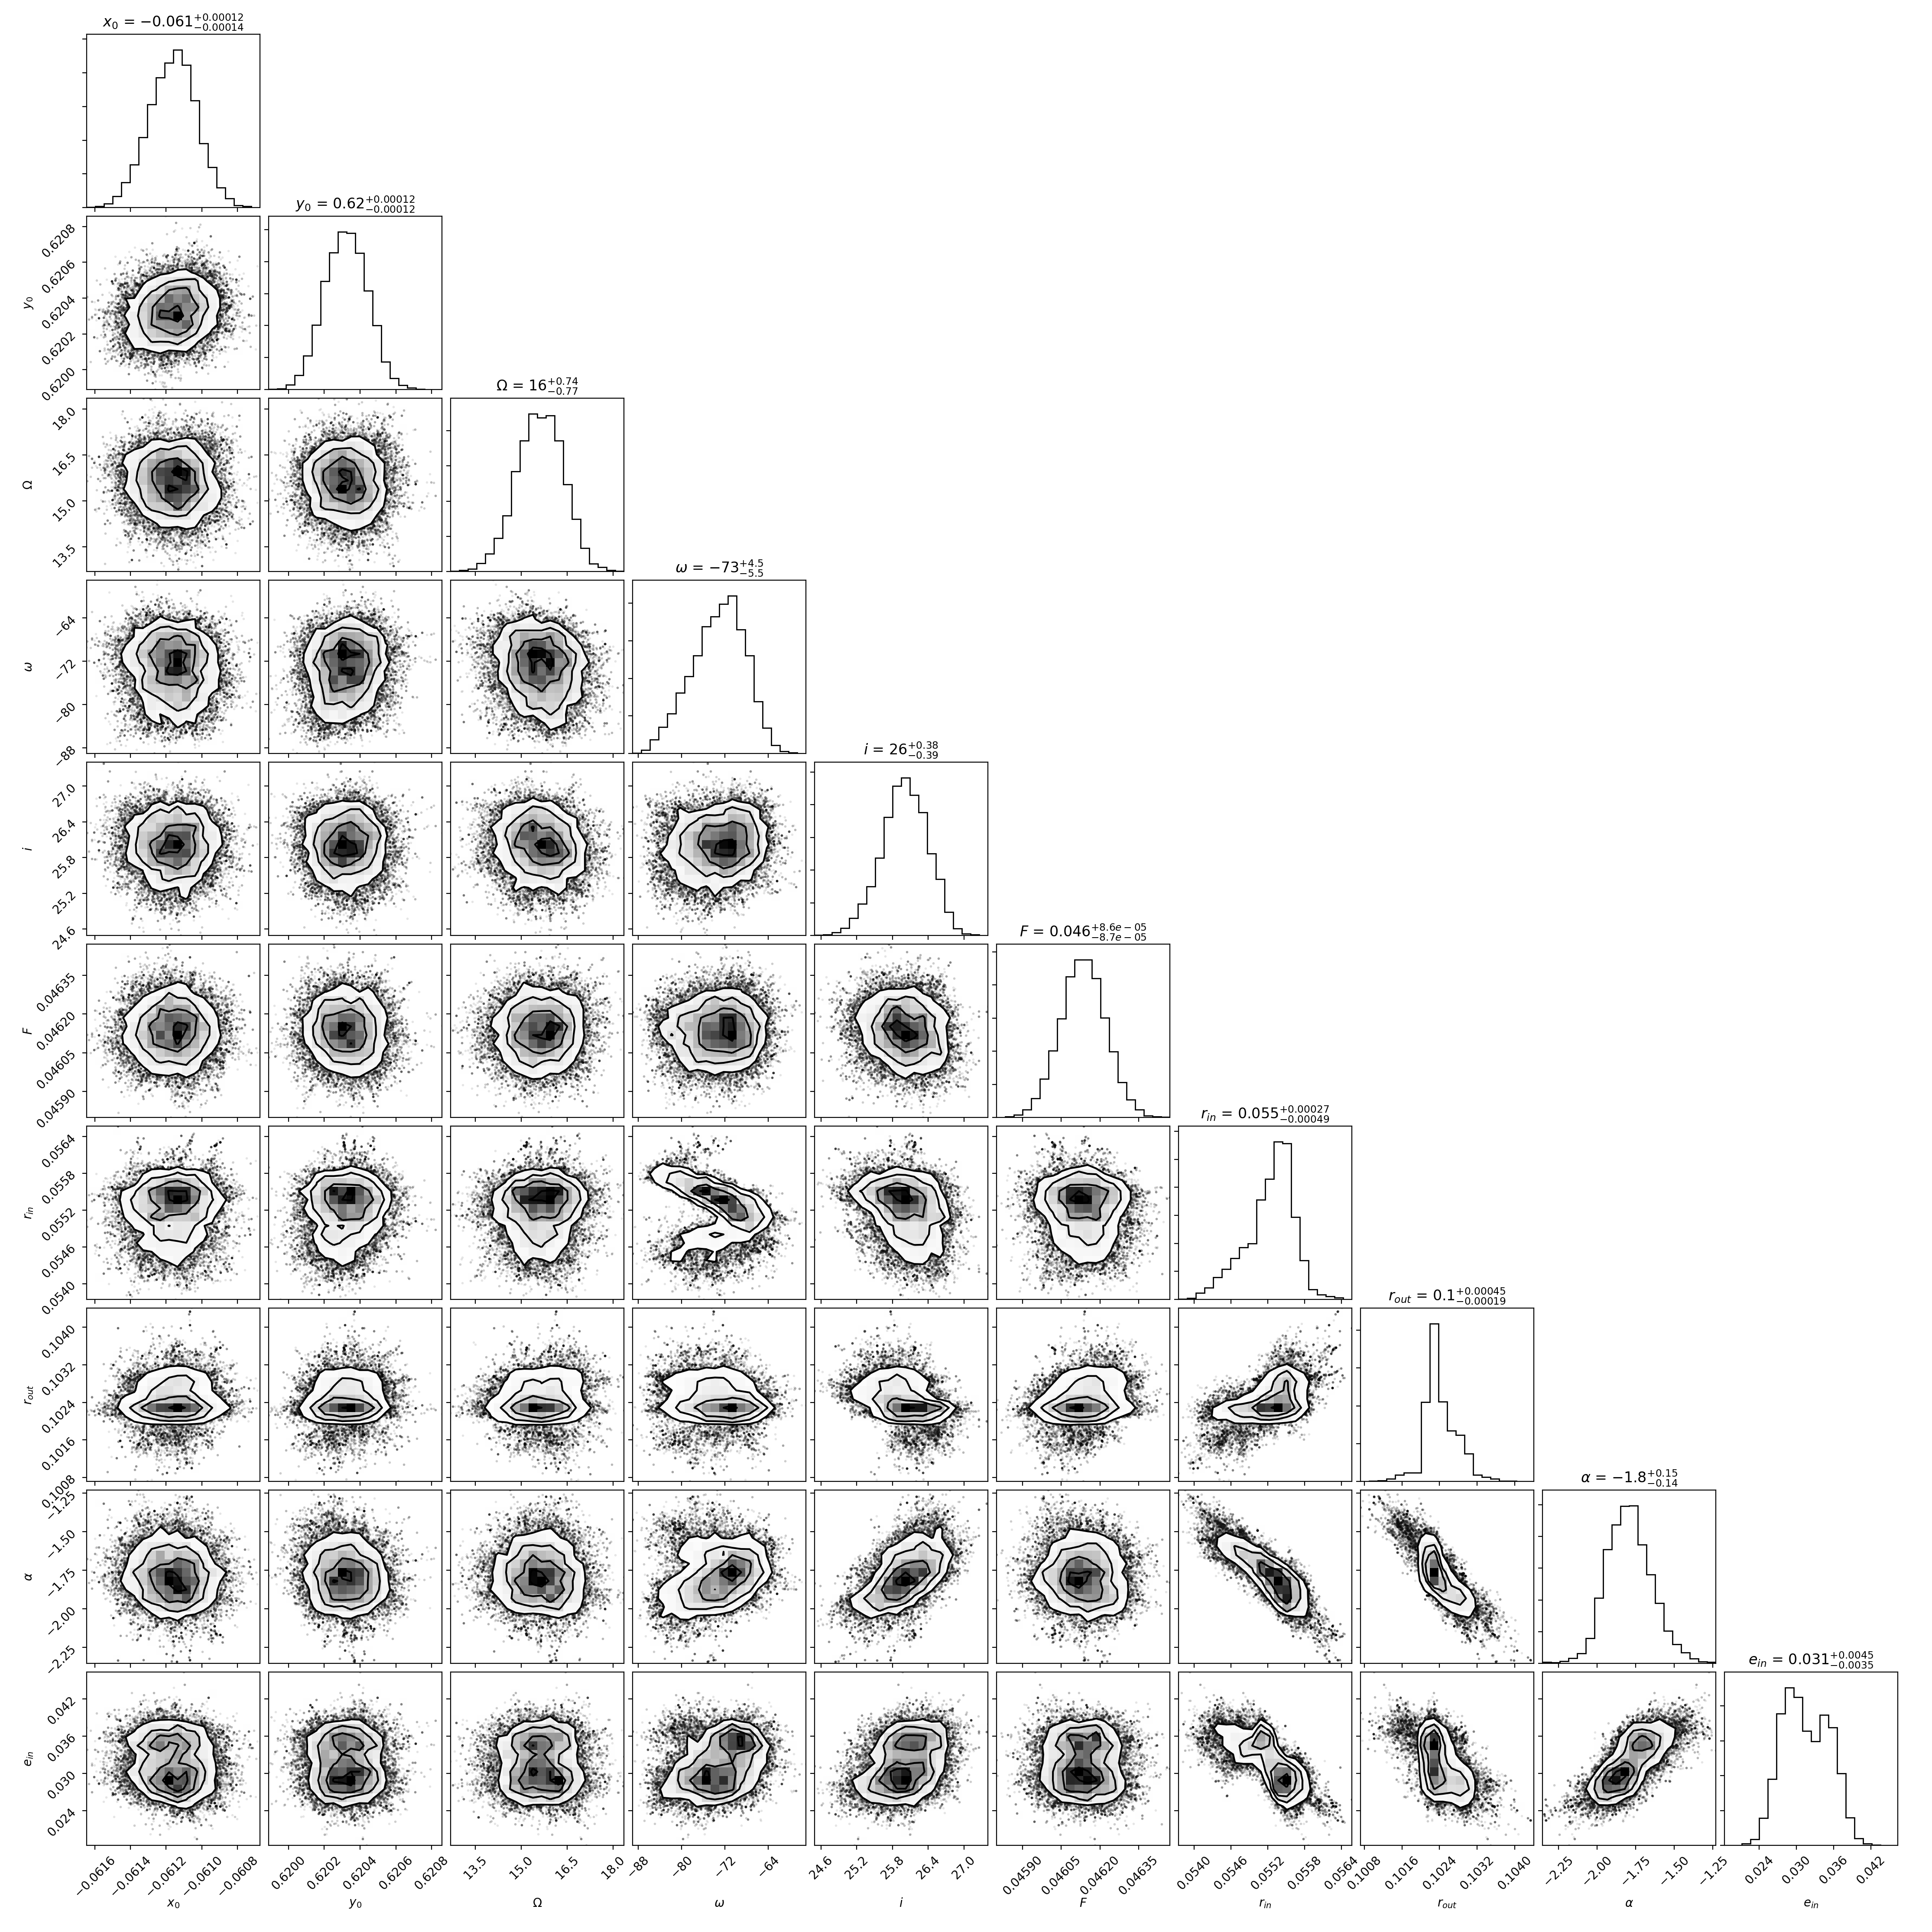

In [20]:
# make the corner plot
fig = corner.corner(chain[:,burn:,:].reshape((-1,ndim)), labels=labels,
                    show_titles=True, title_fmt='.2g')

fig.savefig(model_name+'/corner-'+model_name+'.pdf')

[-0.06109472  0.62013206 15.64094777 26.12897316  0.04612627  0.05466883
  0.10222018 -1.63302018]
[1.31911317e-04 1.12785061e-04 7.67211859e-01 3.54010213e-01
 8.86534938e-05 3.71650295e-04 2.91475793e-04 1.14029173e-01]
radial r_max: 22 pix at -13.181605432888437,133.7977529936655
model x,y,z extent 21, 22, 26


<IPython.core.display.Javascript object>


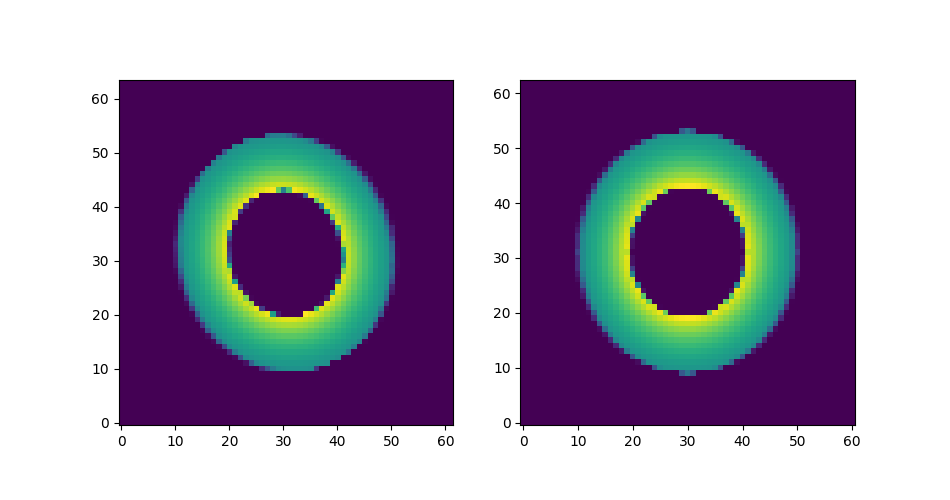

In [15]:
# get the best fit parameters
# i = np.unravel_index(np.argmax(sampler.lnprobability), sampler.lnprobability.shape)
# p = sampler.chain[i]
p = np.median(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
s = np.std(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
print(p)
print(s)

# recompute the limits for the full rotated image
ii.compute_rmax(p)
im = ii.image(p)

fig,ax = plt.subplots(1,2, figsize=(9.5,5))
ax[0].imshow(im[ii.cc], origin='bottom')
ax[1].imshow(ii.image_galario(p[3:])[ii.cc_gal], origin='bottom')
fig.savefig(model_name+'/best-'+model_name+'.png')

In [16]:
# and median, uncertainty ranges
chain = sampler.chain
med = np.percentile(chain[:,burn:,:].reshape((-1,ndim)), 50, axis=0)
lo = med - np.percentile(chain[:,burn:,:].reshape((-1,ndim)), 16, axis=0)
hi = np.percentile(chain[:,burn:,:].reshape((-1,ndim)), 84, axis=0) - med

for pn,m,l,h in zip(labels,med,lo,hi):
    print('{}\t{:g} - {:g} + {:g}'.format(pn,m,l,h))
    
# latex
for pn,m,l,h in zip(labels,med,lo,hi):
    print('{} & {:g} & {:g} \\\\'.format(pn,m,(l+h)/2.))

$x_0$	-0.0611577 - 0.000138992 + 0.000124113
$y_0$	0.620322 - 0.000118068 + 0.000118708
$\Omega$	15.626 - 0.771734 + 0.742054
$\omega$	-72.84 - 5.53912 + 4.53401
$i$	26.0132 - 0.386227 + 0.376349
$F$	0.0461343 - 8.72823e-05 + 8.59319e-05
$r_{in}$	0.0553055 - 0.000491789 + 0.000273341
$r_{out}$	0.102343 - 0.00018566 + 0.000447568
$\alpha$	-1.79535 - 0.136848 + 0.150523
$e_{in}$	0.03118 - 0.00352197 + 0.00453979
$x_0$ & -0.0611577 & 0.000131552 \\
$y_0$ & 0.620322 & 0.000118388 \\
$\Omega$ & 15.626 & 0.756894 \\
$\omega$ & -72.84 & 5.03657 \\
$i$ & 26.0132 & 0.381288 \\
$F$ & 0.0461343 & 8.66071e-05 \\
$r_{in}$ & 0.0553055 & 0.000382565 \\
$r_{out}$ & 0.102343 & 0.000316614 \\
$\alpha$ & -1.79535 & 0.143685 \\
$e_{in}$ & 0.03118 & 0.00403088 \\


In [17]:
# save the visibilities for subtraction from the data
vis_mod = gd.sampleImage(ii.pb_galario * ii.image_galario(p[3:]), dxy, u, v, dRA = p[0]*arcsec, 
                        dDec = p[1]*arcsec, PA = np.deg2rad(p[2]) )
np.save(model_name+'/vis-'+model_name+'.npy', vis_mod)

<IPython.core.display.Javascript object>


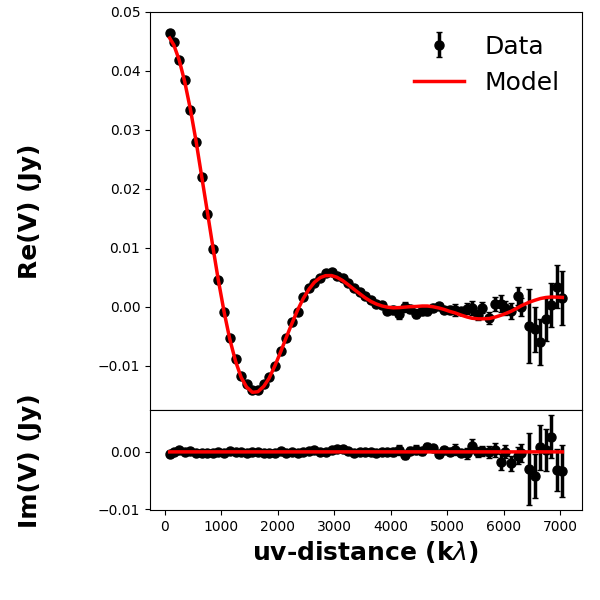

In [18]:
# make a uv distance plot
uvbin_size = 1e5     # uv-distance bin [wle]

uv = UVTable(uvtable=(u*wavelength, v*wavelength, Re, Im, w), wle=wavelength)
uv.apply_phase(-p[0]*arcsec, -p[1]*arcsec)
uv.deproject(np.deg2rad(p[3]), np.deg2rad(p[2]))

uv_mod = UVTable(uvtable=(u*wavelength, v*wavelength, np.real(vis_mod), np.imag(vis_mod), w), wle=wavelength)
uv_mod.apply_phase(-p[0]*arcsec, -p[1]*arcsec)
uv_mod.deproject(np.deg2rad(p[3]), np.deg2rad(p[2]))

axes = uv.plot(label='Data', uvbin_size=uvbin_size)
uv_mod.plot(label='Model', uvbin_size=uvbin_size, axes=axes, yerr=False, linestyle='-', color='r')
axes[0].figure.savefig(model_name+'/uvplot-'+model_name+'.png')